In [1]:
import os
os.chdir('D:\\Gnan\\DA\\KMU\\Prediction-COVID-19')
from utils import *
from model import *
from trainer import *

from torch.optim.adam import Adam
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
#path = 'Data/SIR_Origin/*.csv'
#dic_files = Load_files.load_files(path, -17, -15)
#path = 'Data/Cleaned_deathCnt/*.csv'
#dic_files = Load_files.load_files(path, -14, -12)
path = 'Data/Variants/alpha_delta/*.csv'
dic_files = Load_files.load_files(path, -18, -16)
data = dic_files['대구']
data

,stdDay,incDec,alpha_variants,delta_variants
0,2021-04-12,16.0,4.16,0.32
1,2021-04-13,9.0,2.34,0.18
2,2021-04-14,11.0,2.86,0.22
3,2021-04-15,18.0,4.68,0.36
4,2021-04-16,4.0,1.04,0.08
...,...,...,...,...
121,2021-08-11,66.0,0.66,62.70
122,2021-08-12,39.0,0.39,37.05
123,2021-08-13,57.0,0.57,54.15
124,2021-08-14,82.0,0.82,77.90


In [3]:
criterion = nn.MSELoss()
lr = 1e-4
patience = 20
hidden_size = 32
num_layers = 4
batch_size = 8
dropout = 0.25

input_size = 3
sequence_length = 60
num_epochs = 2000

df = Prepare_df.processing(data, 'stdDay', 'delta_variants')

x = df.iloc[:, 0:]
y = df.iloc[:,:1]

ms = MinMaxScaler()
ss = StandardScaler()

ss.fit(x)
ms.fit(y)

x, y, x_ss, y_ms, train_loader, test_loader = Prepare_df.split_data(df, 51, 60, 7, batch_size, 'mtm')

model_GRU_seq2seq = GRU_encoder_decoder(input_size = input_size,
                                        hidden_size = hidden_size,
                                        num_layers = num_layers, 
                                        dropout = dropout, 
                                        device = device).to(device)

model = model_GRU_seq2seq

optimizer = Adam(model.parameters(), lr = lr)

torch.Size([51, 60, 3])
torch.Size([51, 7, 1])
torch.Size([7, 60, 3])
torch.Size([7, 7, 1])


In [4]:
loss_list, model = Trainer.Many_to_Many(train_loader, 
                                        test_loader, 
                                        model, 
                                        criterion, 
                                        optimizer, 
                                        num_epochs, 
                                        patience,
                                        device)

epoch: 100 loss: 0.015077

 Early Stopping / epoch: 101 loss: 0.014253


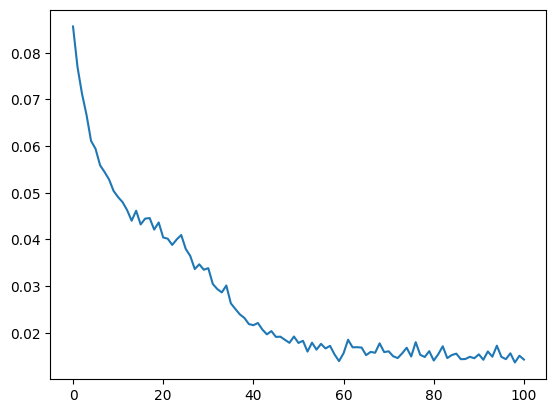

In [5]:
plt.plot(loss_list)

149.04022216796875


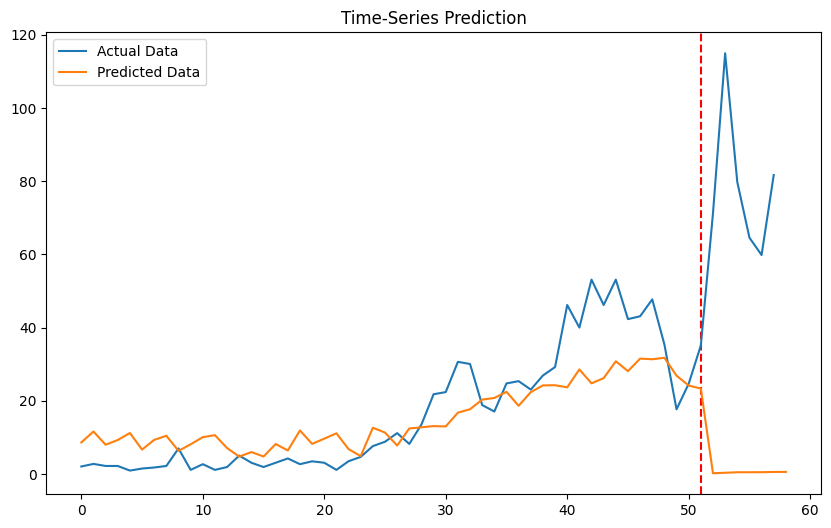

In [6]:
label_y, predicted, first_label_y, first_predicted = predict_mtm(model, df, x_ss, y_ms, 58, 7, 0.5, device)
print(mape(first_label_y, first_predicted))
final_predicted = np.concatenate((first_predicted.squeeze(-1)[:-6], predicted[-1].squeeze(-1)))
plotting(first_label_y, final_predicted, 51)

In [ ]:
torch.save(model.state_dict(), 'Capstone/alpha_2weeks_seq2seqGRU.pth')